In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
import astropy

In [2]:
#from platform import python_version
#python_version()

In [3]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.linewidth'] = 1.0


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

## Getting the directory name

In [4]:
import os
directory_path = os.getcwd()
nome_aglo = directory_path.split('/')[-1]
nome_aglo

'ESO_96-4'

## Getting RA&DEC from Bica 2019

In [5]:
df = pd.read_csv('../../lista.txt', comment= '#')
ra, dec = df.loc[df['Nome'] == nome_aglo]['_RAJ2000'].values[0], df.loc[df['Nome'] == nome_aglo]['_DEJ2000'].values[0]
ra, dec

(198.81667, -65.92083)

## Querying the data

In [6]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [7]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


In [8]:
query = """SELECT 
ra, dec, pmra, pmra_error, pmdec, pmdec_error, bp_rp, phot_g_mean_mag, parallax, parallax_error, radial_velocity, radial_velocity_error, l,b
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(POINT('ICRS',ra,dec),
CIRCLE('ICRS', """ +  str(ra) + ',' + str(dec) + ',' + ' 0.2))'

In [9]:
job = Gaia.launch_job_async(query)
job

INFO: Query finished. [astroquery.utils.tap.core]


In [10]:
data = job.get_results()
len(data)

76107

In [11]:
#data

## Converting to pandas

In [12]:
df = data.to_pandas()
df

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
0,199.264160,-65.858084,-2.639256,0.854409,0.745991,1.124679,NaN,20.420511,0.102285,0.680531,NaN,NaN,305.550754,-3.116684
1,199.234225,-65.877957,-4.914743,1.334083,3.905511,1.709122,NaN,20.715286,-1.290598,1.055421,NaN,NaN,305.536584,-3.135246
2,199.242686,-65.880312,-6.252504,0.009549,-1.697968,0.012842,0.827933,12.590611,0.638331,0.011031,-16.600843,4.256691,305.539796,-3.137931
3,199.236745,-65.875248,-11.059842,0.131511,-1.482877,0.164005,1.502378,18.036749,0.806859,0.146170,NaN,NaN,305.537879,-3.132651
4,199.255334,-65.872921,-5.952978,0.083866,-1.532955,0.110835,1.292730,17.925440,0.419109,0.097579,NaN,NaN,305.545682,-3.131089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76102,198.627221,-65.738098,-6.615484,1.075624,-4.120350,2.231746,1.066072,20.841154,3.772392,1.732768,NaN,NaN,305.301795,-2.972563
76103,198.636795,-65.735311,-2.685023,2.299838,2.836173,2.251486,1.622093,20.978037,-0.229591,1.744897,NaN,NaN,305.305969,-2.970140
76104,198.614720,-65.741571,-6.262462,0.044313,-1.907442,0.059030,1.536798,16.738089,0.229987,0.049715,NaN,NaN,305.296361,-2.975563
76105,198.613538,-65.739153,-6.719451,0.130550,-1.332444,0.163462,1.370474,18.297220,0.240641,0.144153,NaN,NaN,305.296093,-2.973111


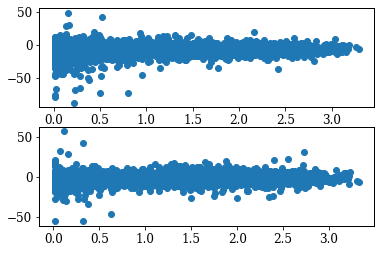

In [13]:
fig, ax = plt.subplots(2)

ax[0].scatter(df.pmra_error,df.pmra)
ax[1].scatter(df.pmdec_error,df.pmdec)

In [14]:
print(np.mean(df.pmdec), np.mean(df.pmdec_error)) ## por que pmra tem um erro muito maior?
print(np.mean(df.pmra), np.mean(df.pmra_error))

-1.1055994376873322 0.5844190120697021
-6.557620418394209 0.4983721077442169


## Applying better conditions to the variables

In [15]:
condicao = np.abs(0.5*df.pmra) < df.pmra_error
condicao2 = np.abs(0.5*df.pmdec) < df.pmdec_error
condicao3 = np.abs(0.5*df.parallax) < df.parallax_error


df_condicionado = df.drop(df[condicao|condicao2|condicao3].index) #
len(df_condicionado),len(df)

(26402, 76107)

## Dropping uknown values of pmra, pmdec or parallax.

In [16]:
ndf = df_condicionado.dropna(how='any',subset=['pmra', 'pmdec', 'parallax'])
ndf

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
2,199.242686,-65.880312,-6.252504,0.009549,-1.697968,0.012842,0.827933,12.590611,0.638331,0.011031,-16.600843,4.256691,305.539796,-3.137931
3,199.236745,-65.875248,-11.059842,0.131511,-1.482877,0.164005,1.502378,18.036749,0.806859,0.146170,NaN,NaN,305.537879,-3.132651
4,199.255334,-65.872921,-5.952978,0.083866,-1.532955,0.110835,1.292730,17.925440,0.419109,0.097579,NaN,NaN,305.545682,-3.131089
5,199.261054,-65.870121,-8.667539,0.143551,-1.964048,0.184898,1.332773,18.272717,0.505959,0.171164,NaN,NaN,305.548291,-3.128535
8,199.250824,-65.866682,-3.128507,0.012789,-1.759606,0.016545,1.618999,14.007032,0.266445,0.015173,-64.918060,1.961821,305.544465,-3.124699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76076,198.607158,-65.743750,-6.165802,0.067157,0.370661,0.081388,1.244532,17.410770,0.243951,0.069876,NaN,NaN,305.293068,-2.977455
76083,198.618863,-65.741000,-4.814465,0.071280,-0.508165,0.087830,1.952469,17.425390,-0.177377,0.075087,NaN,NaN,305.298110,-2.975146
76090,198.621907,-65.739482,-6.468636,0.102603,-1.091947,0.129356,1.092131,18.143456,0.329739,0.111261,NaN,NaN,305.299493,-2.973746
76100,198.614483,-65.742153,-13.592776,0.552123,-2.673419,0.714758,NaN,20.257549,2.057531,0.648323,NaN,NaN,305.296212,-2.976133


In [17]:
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import silhouette_score
#from sklearn.metrics import v_measure_score
from sklearn.preprocessing import StandardScaler

## Creating the arrays to perform the 5-D HDBSCAN fit

In [18]:
X = np.dstack((ndf['pmra'],ndf['pmdec']))[0]
cincoD = np.dstack((ndf['pmra'],ndf['pmdec'],ndf['ra'],ndf['dec'],ndf['parallax']))[0]

In [19]:
sc = StandardScaler()

escalada = sc.fit_transform(cincoD)

## Performing the HDBSCAN

In [20]:
import hdbscan

Estimated no. of clusters: 1
Estimated no. of noise points: 14503
Estimated no. points clustered: 528


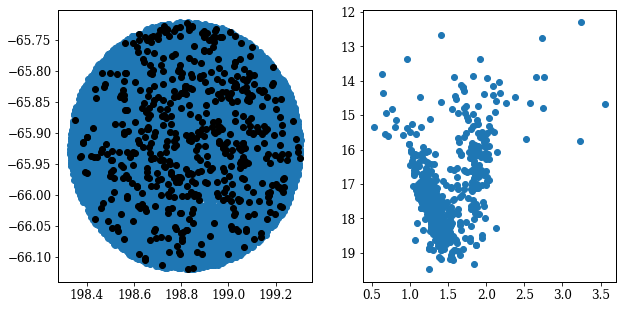

In [21]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples = 1, allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(cincoD)

labels = clusterer.labels_


ndf = ndf.assign(labels=labels)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)

ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


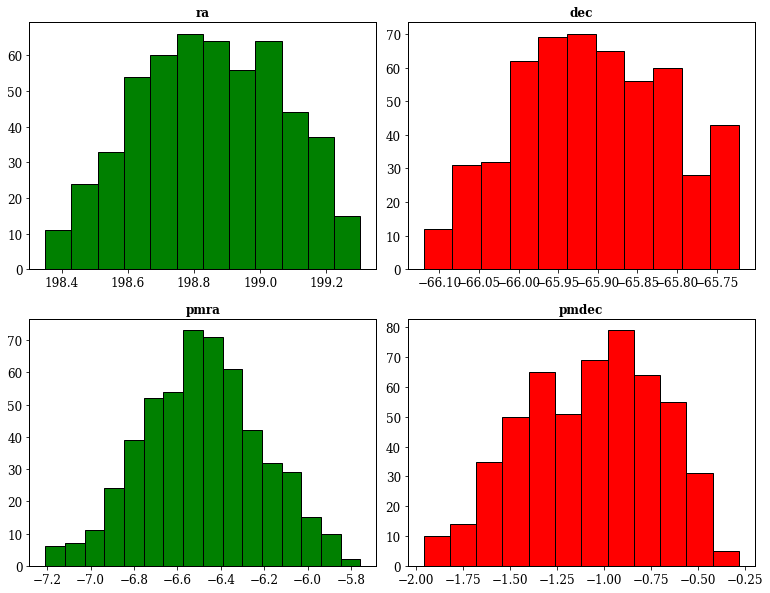

In [22]:
fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(subset['ra'], bins = 'fd')
ax1.hist(subset['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['pmra'], bins = 'fd')
ax2.hist(subset['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['dec'], bins = 'fd')
ax3.hist(subset['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(subset['pmdec'], bins = 'fd')
ax4.hist(subset['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


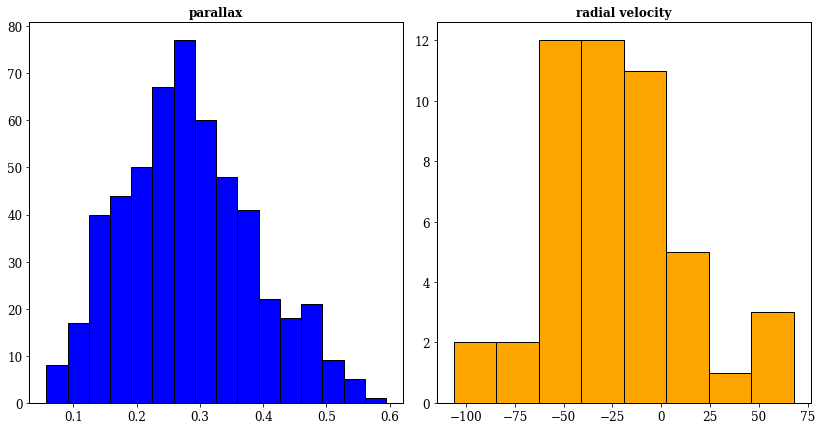

In [23]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(subset['parallax'], bins = 'fd')
ax1.hist(subset['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

## Constructing a RDP and histograms of the clusters parameters

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

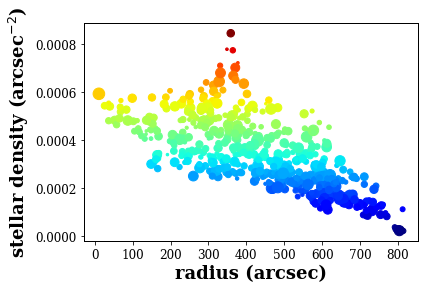

In [24]:
from astropy.coordinates import SkyCoord
from astropy import units
from sklearn.neighbors import NearestNeighbors


catalog = SkyCoord(ra=subset['ra']*units.degree, dec=subset['dec']*units.degree, frame='fk5')

nstar = len(subset)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([subset['ra']*np.cos(subset['dec']*np.pi/180.0), subset['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(subset['ra'], weights=den_data)
std_x = np.average((subset['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(subset['dec'], weights=den_data)
std_y = np.average((subset['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value

#.criando figura do RDP

import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()#1,1,figsize=(10,11))
ax.scatter(radii,den_data, s=(max(subset['phot_g_mean_mag'])-subset['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



## Gaussian fit

In [25]:
def gaussiana(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

from lmfit.models import GaussianModel

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 16
    # variables        = 3
    chi-square         = 457.759269
    reduced chi-square = 35.2122515
    Akaike info crit   = 59.6600754
    Bayesian info crit = 61.9778415
[[Variables]]
    amplitude:  19.0401687 +/- 0.89117791 (4.68%) (init = 28.54818)
    center:     0.26607186 +/- 0.00601772 (2.26%) (init = 0.2542079)
    sigma:      0.11279653 +/- 0.00624995 (5.54%) (init = 0.1252113)
    fwhm:       0.26561554 +/- 0.01471752 (5.54%) == '2.3548200*sigma'
    height:     67.3418621 +/- 3.10786731 (4.62%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.604


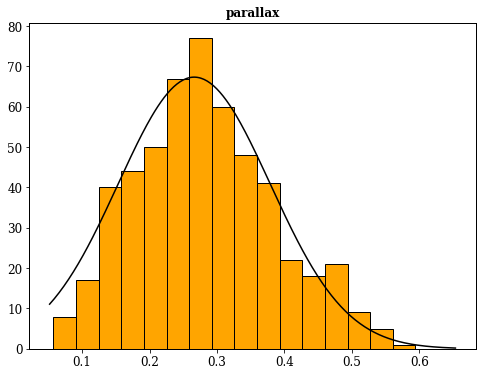

In [26]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['parallax']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'orange');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(0.9*bins[0],1.1*bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('parallax', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 12
    # variables        = 3
    chi-square         = 284.944945
    reduced chi-square = 31.6605495
    Akaike info crit   = 44.0086720
    Bayesian info crit = 45.4633920
[[Variables]]
    amplitude:  49.8526489 +/- 2.32988539 (4.67%) (init = 42.92227)
    center:     198.857256 +/- 0.01483757 (0.01%) (init = 198.8698)
    sigma:      0.29322737 +/- 0.01720902 (5.87%) (init = 0.2601349)
    fwhm:       0.69049768 +/- 0.04052415 (5.87%) == '2.3548200*sigma'
    height:     67.8256275 +/- 2.93876153 (4.33%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.684


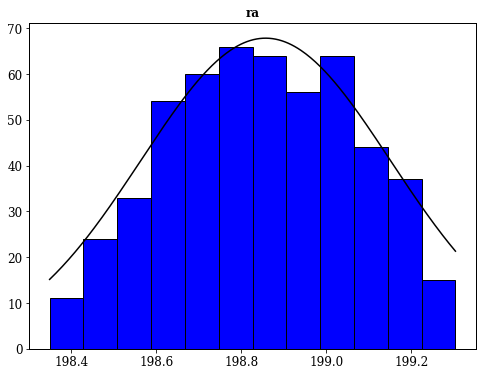

In [27]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('ra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 16
    # variables        = 3
    chi-square         = 223.671249
    reduced chi-square = 17.2054807
    Akaike info crit   = 48.2014178
    Bayesian info crit = 50.5191840
[[Variables]]
    amplitude:  51.3639662 +/- 1.63436640 (3.18%) (init = 61.89925)
    center:    -6.48822356 +/- 0.01092279 (0.17%) (init = -6.531612)
    sigma:      0.29832294 +/- 0.01103572 (3.70%) (init = 0.2906068)
    fwhm:       0.70249683 +/- 0.02598713 (3.70%) == '2.3548200*sigma'
    height:     68.6881766 +/- 2.18095806 (3.18%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.583


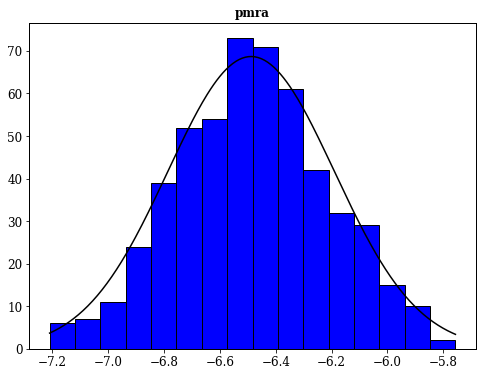

In [28]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmra= [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 11
    # variables        = 3
    chi-square         = 723.193798
    reduced chi-square = 90.3992247
    Akaike info crit   = 52.0436016
    Bayesian info crit = 53.2372874
[[Variables]]
    amplitude:  23.5588407 +/- 1.94931750 (8.27%) (init = 24.25761)
    center:    -65.9010873 +/- 0.01164692 (0.02%) (init = -65.87543)
    sigma:      0.13468379 +/- 0.01429631 (10.61%) (init = 0.1394116)
    fwhm:       0.31715609 +/- 0.03366524 (10.61%) == '2.3548200*sigma'
    height:     69.7828428 +/- 5.05570266 (7.24%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.732
    C(center, sigma)     = 0.124
    C(amplitude, center) = 0.111


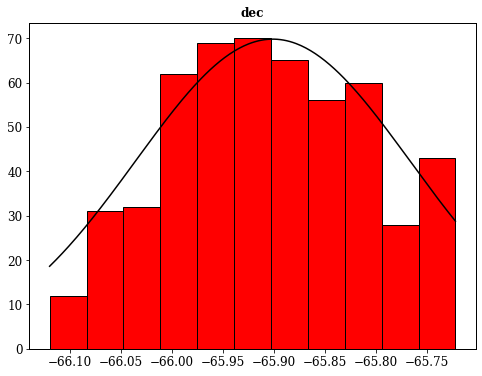

In [29]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_dec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('dec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 12
    # variables        = 3
    chi-square         = 858.508742
    reduced chi-square = 95.3898602
    Akaike info crit   = 57.2434826
    Bayesian info crit = 58.6982025
[[Variables]]
    amplitude:  85.7452624 +/- 6.41879344 (7.49%) (init = 101.5814)
    center:    -1.03202437 +/- 0.03871112 (3.75%) (init = -1.045221)
    sigma:      0.46424970 +/- 0.04250495 (9.16%) (init = 0.4575741)
    fwhm:       1.09322447 +/- 0.10009152 (9.16%) == '2.3548200*sigma'
    height:     73.6832192 +/- 5.29139122 (7.18%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.644


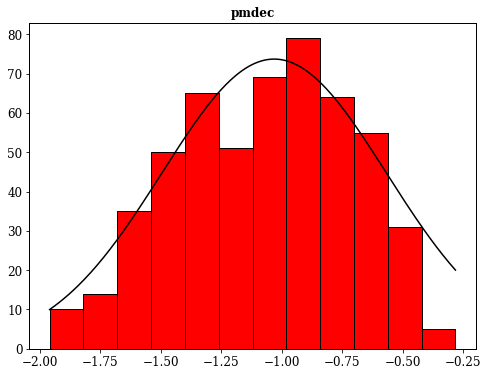

In [30]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmdec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 8
    # variables        = 3
    chi-square         = 20.4132755
    reduced chi-square = 4.08265511
    Akaike info crit   = 13.4939513
    Bayesian info crit = 13.7322759
[[Variables]]
    amplitude:  1142.91822 +/- 136.411718 (11.94%) (init = 820.8019)
    center:    -29.8032599 +/- 4.72380467 (15.85%) (init = -31.66308)
    sigma:      34.3244112 +/- 4.74369262 (13.82%) (init = 24.87279)
    fwhm:       80.8278100 +/- 11.1705422 (13.82%) == '2.3548200*sigma'
    height:     13.2837945 +/- 1.58423908 (11.93%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.580


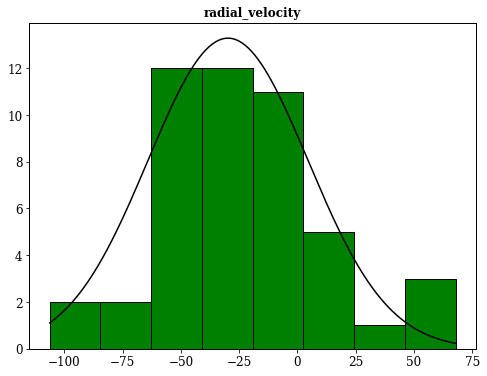

In [31]:
fig, ax = plt.subplots(figsize=(8,6))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'green');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]

valores_radial_velocity= [result.params['center'].value, result.params['sigma'].value]


xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('radial_velocity', fontweight = 'bold')

plt.show()

## Sigma Clipping

528
122


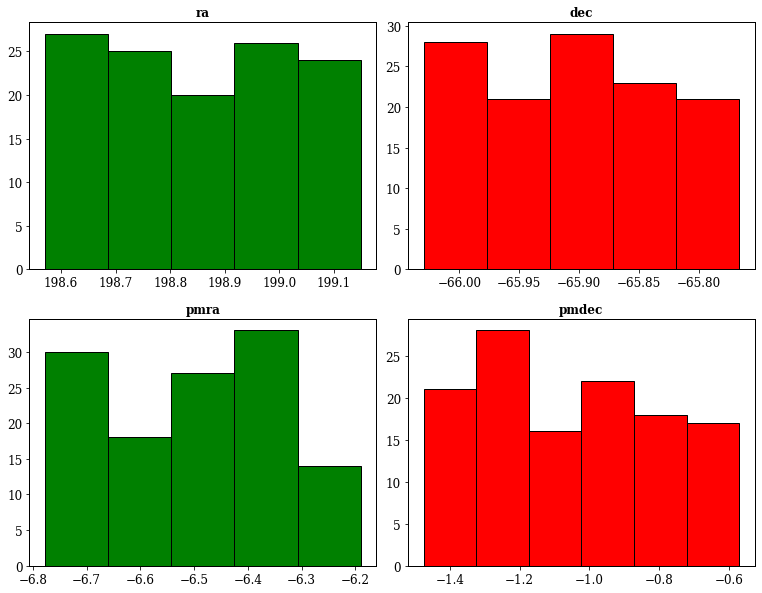

In [32]:
gmodel = GaussianModel()
clip_loop = subset

for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 1

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    ra_up, ra_down = valores_ra[0] + sigma*valores_ra[1], valores_ra[0] - sigma*valores_ra[1]
    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]
    dec_up, dec_down = valores_dec[0] + sigma*valores_dec[1], valores_dec[0] - sigma*valores_dec[1]
    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down) & (clip_loop.ra>ra_down) & (clip_loop.ra<ra_up) & 
                              (clip_loop.dec>dec_down) & (clip_loop.dec<dec_up) & (clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)  & (clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

    
print(len(clip_loop))

fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax1.hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax2.hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax3.hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax4.hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


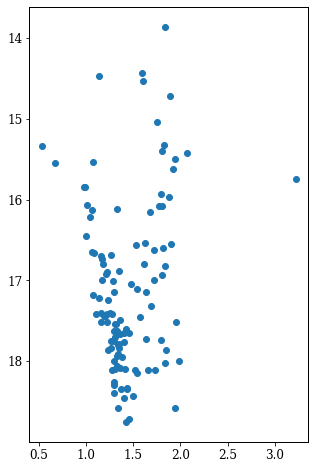

In [33]:
plt.figure(figsize=(5,8))
plt.scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'])
plt.gca().invert_yaxis()

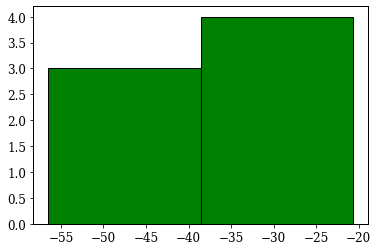

In [34]:
ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']

plt.hist(data, optimal_bin, ec = 'k',color = 'green');

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

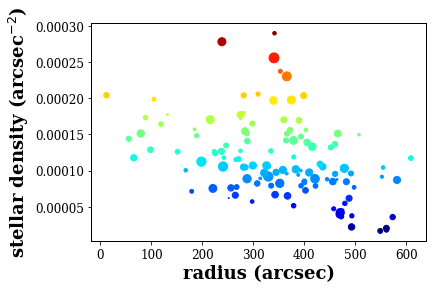

In [35]:
from astropy.coordinates import SkyCoord
from astropy import units

catalog = SkyCoord(ra=clip_loop['ra']*units.degree, dec=clip_loop['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([clip_loop['ra']*np.cos(clip_loop['dec']*np.pi/180.0), clip_loop['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(clip_loop['ra'], weights=den_data)
std_x = np.average((clip_loop['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(clip_loop['dec'], weights=den_data)
std_y = np.average((clip_loop['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()
ax.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



In [36]:
center

<SkyCoord (ICRS): (ra, dec) in deg
    (198.8716388, -65.90235584)>

In [37]:
final = df.loc[(df.parallax < paralaxe_up ) & (df.parallax > paralaxe_down) & (df.ra>ra_down) & (df.ra<ra_up) & 
                              (df.dec>dec_down) & (df.dec<dec_up) & (df.pmra>pmra_down) & (df.pmra<pmra_up) & (df.pmdec>pmdec_down) 
                              & (df.pmdec<pmdec_up)  & (df.radial_velocity.isnull() | (df.radial_velocity>radvel_down) & (df.radial_velocity<radvel_up)) ]

In [38]:
clip_loop.to_csv('final_5d.csv', index=False)

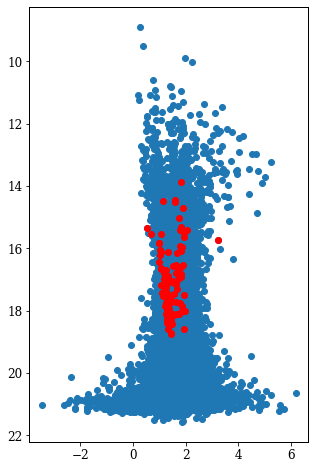

In [39]:
plt.figure(figsize=(5,8))
plt.scatter(df['bp_rp'],df['phot_g_mean_mag'])
plt.scatter(clip_loop['bp_rp'], clip_loop['phot_g_mean_mag'], color = 'red')
plt.gca().invert_yaxis()

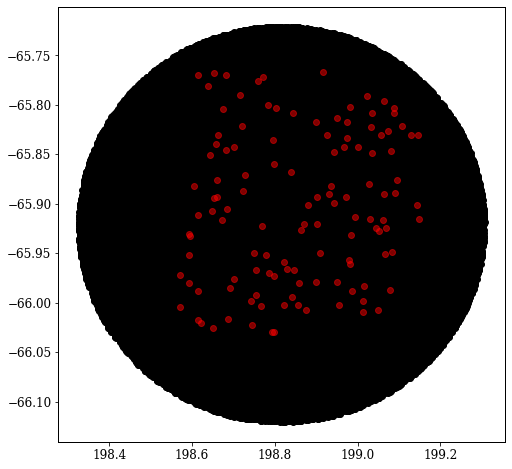

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(df['ra'],df['dec'], color = 'k')
plt.scatter(clip_loop['ra'],clip_loop['dec'], color = 'red', alpha = 0.5)